In [38]:
import tensorflow as tf 
from tensorflow.keras import layers, models, optimizers
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpu = tf.config.list_physical_devices('GPU')
if gpu:
  # only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpu[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpu), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPU


In [6]:
data = pd.read_csv("..\data3.csv")
data

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall
...,...,...,...,...,...,...,...
96795,7.30,-1.16,-4.58,18.19,3.60,-35.77,light
96796,7.39,-0.37,-5.05,20.08,0.06,-34.55,light
96797,7.52,-1.46,-5.82,22.58,0.12,-28.02,light
96798,7.58,-2.14,-6.31,19.47,2.44,-22.52,light


In [11]:
def split_resampling(data, seed=1218):
    new_data = data.drop("label",axis=1).to_numpy().reshape(-1, 400, 6)
    labels = np.array(data.label.iloc[np.arange(0,data.shape[0], 400)])

    sm = SMOTE(random_state=seed)
    y = labels
    X, y = sm.fit_resample(new_data.reshape(-1, 400*6), y)

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, 400*6))
    X_test = scaler.fit_transform(X_test.reshape(-1, 400*6))

    # reshape
    X_train = X_train.reshape(-1, 400, 6)
    X_test = X_test.reshape(-1, 400, 6)
    input_shape = X_train.shape[1:]
    seq_len, n_features = input_shape

    le = LabelEncoder()
    le.fit(np.unique(y_train))
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=7)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=7)

    X_train = X_train.reshape(-1, seq_len, n_features) 
    X_test = X_test.reshape(-1, seq_len, n_features)

    return X_train, X_test, y_train, y_test, input_shape

In [24]:
X_train, X_test, y_train, y_test, input_shape = split_resampling(data)

In [13]:
X_train.shape

(362, 400, 6)

# First CNN

\begin{align*}
\textbf{Neural Network Architecture: First CNN} \\
\end{align*}

The CNN neural network is designed for the classification of human daily activities and fall behaviors. It is a relatively simple architecture with convolutional and fully connected layers. The network structure is as follows:

\begin{align*}
1. & \text{Input Layer:} \\
   & \text{Accepts data from the triaxial accelerometer and triaxial angular velocity meter and has an input shape defined by } \text{{input\_shape}}. \\
\\
2. & \text{Convolution Layer:} \\
   & \text{Contains 32 filters with a kernel size of 3 and uses the ReLU activation function.} \\
\\
3. & \text{MaxPooling Layer:} \\
   & \text{Performs max-pooling with a pool size of 2 for subsampling.} \\
\\
4. & \text{Flatten Layer:} \\
   & \text{Flattens the output of the previous layers for input to the fully connected layers.} \\
\\
5. & \text{Fully Connected Layer 1:} \\
   & \text{Consists of 64 neurons with ReLU activation.} \\
\\
6. & \text{Fully Connected Layer 2:} \\
   & \text{The output layer consists of 7 neurons with sigmoid activation, providing class probabilities.} \\
\end{align*}

The First Model is trained using an appropriate optimizer, and the loss function is categorical cross-entropy. The performance of the model can be evaluated based on metrics such as accuracy.

This simple First Model neural network is designed to classify human activities and fall behaviors effectively by extracting basic features from accelerometer and gyroscope data and producing class probabilities using a sigmoid activation function in the output layer.


In [23]:
first_model = models.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(7, activation='sigmoid')  
])

In [24]:
first_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [25]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 398, 32)           608       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6368)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                407616    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 408,679
Trainable params: 408,679
Non-trainable params: 0
_________________________________________________________________


In [26]:
first_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
12/12 [==============================] - 13s 52ms/step - loss: 1.0277 - accuracy: 0.6188 - val_loss: 0.6862 - val_accuracy: 0.7851
Epoch 2/50
12/12 [==============================] - 0s 10ms/step - loss: 0.1683 - accuracy: 0.9558 - val_loss: 0.3482 - val_accuracy: 0.8595
Epoch 3/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0538 - accuracy: 0.9779 - val_loss: 0.1046 - val_accuracy: 0.9504
Epoch 4/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0218 - accuracy: 0.9945 - val_loss: 0.0880 - val_accuracy: 0.9669
Epoch 5/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0747 - val_accuracy: 0.9752
Epoch 6/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0783 - val_accuracy: 0.9752
Epoch 7/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0709 - val_accuracy: 0.9752
Epoch 8/50
12/12

In [27]:
first_model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 5ms/step - loss: 0.0587 - accuracy: 0.9752


[0.05871253460645676, 0.9752066135406494]

# CNN-HE

\begin{align*}
\textbf{Neural Network Architecture: CNN-HE (Convolutional Neural Network with Heuristic Enhancements)} \\
\end{align*}

The CNN-HE neural network is designed for the classification of human daily activities and fall behaviors. It utilizes convolutional layers and heuristic enhancements to improve accuracy in fall detection. The network structure consists of the following layers:

\begin{align*}
1. & \text{Input Layer:} \\
   & \text{Accepts data from the triaxial accelerometer and triaxial angular velocity meter and inputs them into the convolution layer and bidirectional LSTM layer, respectively.} \\
\\
2. & \text{Convolution Layer 1:} \\
   & \text{Performs 1D convolution with 32 filters, each with a kernel size of 5 and ReLU activation function.} \\
\\
3. & \text{MaxPooling Layer 1:} \\
   & \text{Applies max-pooling with a pool size of 2 to perform subsampling.} \\
\\
4. & \text{Convolution Layer 2:} \\
   & \text{Performs 1D convolution with 64 filters, each with a kernel size of 5 and ReLU activation function.} \\
\\
5. & \text{MaxPooling Layer 2:} \\
   & \text{Applies max-pooling with a pool size of 2 to perform subsampling.} \\
\\
6. & \text{Flatten Layer:} \\
   & \text{Flattens the output of the previous layers for input to the fully connected layers.} \\
\\
7. & \text{Fully Connected Layer 1:} \\
   & \text{Consists of 512 neurons with ReLU activation function.} \\
\\
8. & \text{Fully Connected Layer 2:} \\
   & \text{Consists of 7 neurons with softmax activation, which produces the final classification probabilities for 7 classes.} \\
\end{align*}

The network is trained using the Adam optimizer with a categorical cross-entropy loss function. During training, the model is trained for 70 epochs with a batch size of 64. The model's performance is evaluated on a validation dataset, and metrics such as accuracy are computed.

This CNN-HE neural network is designed to effectively classify human activities and fall behaviors by extracting meaningful features from accelerometer and gyroscope data and utilizing heuristic enhancements to improve the accuracy of fall detection.


In [28]:
cnn_he = models.Sequential([
    layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(7, activation='softmax')
])

cnn_he.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

cnn_he.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/70
6/6 [==============================] - 2s 223ms/step - loss: 2.3598 - accuracy: 0.4033 - val_loss: 1.9100 - val_accuracy: 0.2810
Epoch 2/70
6/6 [==============================] - 0s 19ms/step - loss: 0.8776 - accuracy: 0.7017 - val_loss: 0.6274 - val_accuracy: 0.8678
Epoch 3/70
6/6 [==============================] - 0s 19ms/step - loss: 0.3119 - accuracy: 0.9641 - val_loss: 0.3448 - val_accuracy: 0.8926
Epoch 4/70
6/6 [==============================] - 0s 19ms/step - loss: 0.1115 - accuracy: 0.9751 - val_loss: 0.1847 - val_accuracy: 0.9504
Epoch 5/70
6/6 [==============================] - 0s 18ms/step - loss: 0.0410 - accuracy: 0.9917 - val_loss: 0.1053 - val_accuracy: 0.9587
Epoch 6/70
6/6 [==============================] - 0s 21ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.1016 - val_accuracy: 0.9504
Epoch 7/70
6/6 [==============================] - 0s 17ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0917 - val_accuracy: 0.9587
Epoch 8/70
6/6 [==========

# CNN-3B3Conv

\begin{align*}
\textbf{NN Architecture: CNN-3B3Conv (Convolutional Neural Network with Three Blocks of Three Convolutions)} \\
\end{align*}

The CNN-3B3Conv neural network is designed for the classification of human daily activities and fall behaviors. It consists of three blocks, each containing three 1D convolutional layers with ReLU activation functions. The network structure is as follows:

\begin{align*}
1. & \text{Input Layer:} \\
   & \text{Accepts data from the triaxial accelerometer and triaxial angular velocity meter and has an input shape defined by } \text{{input\_shape}}. \\
\\
2. & \text{Block 1:} \\
   & \text{Contains three 1D convolutional layers with 128 filters each and kernel sizes of 4. Each convolutional layer uses the ReLU activation function.} \\
\\
3. & \text{MaxPooling Layer 1:} \\
   & \text{Performs max-pooling with a pool size of 2 for subsampling.} \\
\\
4. & \text{Block 2:} \\
   & \text{Similar to Block 1, contains three 1D convolutional layers with 128 filters each and kernel sizes of 3. All layers use ReLU activation functions.} \\
\\
5. & \text{MaxPooling Layer 2:} \\
   & \text{Performs max-pooling with a pool size of 2 for subsampling.} \\
\\
6. & \text{Flatten Layer:} \\
   & \text{Flattens the output of the previous layers for input to the fully connected layers.} \\
\\
7. & \text{Fully Connected Layer 1:} \\
   & \text{Consists of 128 neurons with ReLU activation.} \\
\\
8. & \text{Dropout Layer:} \\
   & \text{Applies dropout with a probability of 0.5 to reduce overfitting.} \\
\\
9. & \text{Fully Connected Layer 2:} \\
   & \text{Contains 64 neurons with ReLU activation.} \\
\\
10. & \text{Fully Connected Layer 3:} \\
    & \text{The output layer consists of 7 neurons with softmax activation, providing probabilities for 7 classes.} \\
\end{align*}

The CNN-3B3Conv model is trained using the Adam optimizer with categorical cross-entropy loss. During training, the model is trained for 20 epochs with a batch size of 64. The performance of the model is evaluated on a validation dataset, and metrics such as accuracy are computed.

This CNN-3B3Conv neural network is designed to classify human activities and fall behaviors effectively by leveraging three blocks of three convolutional layers to capture and extract relevant features from accelerometer and gyroscope data. The dropout layer helps prevent overfitting, enhancing the model's generalization ability.


In [29]:
CNN_3B3Conv = models.Sequential([
    layers.Conv1D(128, kernel_size=4, activation='relu', input_shape=input_shape),
    layers.Conv1D(128, kernel_size=4, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(7, activation='softmax')
    ])

CNN_3B3Conv.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
CNN_3B3Conv.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
6/6 [==============================] - 3s 224ms/step - loss: 1.8915 - accuracy: 0.2707 - val_loss: 1.4394 - val_accuracy: 0.6694
Epoch 2/20
6/6 [==============================] - 0s 42ms/step - loss: 1.2125 - accuracy: 0.5856 - val_loss: 0.8283 - val_accuracy: 0.7603
Epoch 3/20
6/6 [==============================] - 0s 43ms/step - loss: 0.7969 - accuracy: 0.7017 - val_loss: 0.5928 - val_accuracy: 0.8512
Epoch 4/20
6/6 [==============================] - 0s 44ms/step - loss: 0.5237 - accuracy: 0.7928 - val_loss: 0.4383 - val_accuracy: 0.8760
Epoch 5/20
6/6 [==============================] - 0s 44ms/step - loss: 0.3553 - accuracy: 0.8591 - val_loss: 0.4250 - val_accuracy: 0.8760
Epoch 6/20
6/6 [==============================] - 0s 44ms/step - loss: 0.2094 - accuracy: 0.9392 - val_loss: 0.2541 - val_accuracy: 0.9174
Epoch 7/20
6/6 [==============================] - 0s 43ms/step - loss: 0.1785 - accuracy: 0.9392 - val_loss: 0.3014 - val_accuracy: 0.8843
Epoch 8/20
6/6 [==========

# CNN EDU

\begin{align*}
\textbf{Neural Network Architecture: CNN-EDU (Convolutional Neural Network with Educational Enhancements)} \\
\end{align*}

The CNN-EDU neural network is designed for the classification of human daily activities and fall behaviors. It features an architecture with multiple convolutional layers and educational enhancements to improve its performance. The network structure is as follows:

\begin{align*}
1. & \text{Input Layer:} \\
   & \text{Accepts data from the triaxial accelerometer and triaxial angular velocity meter and has an input shape defined by } \text{{input\_shape}}. \\
\\
2. & \text{Convolution Layer 1:} \\
   & \text{Contains 16 filters with a kernel size of 5 and uses the ReLU activation function.} \\
\\
3. & \text{MaxPooling Layer 1:} \\
   & \text{Performs max-pooling with a pool size of 2 for subsampling.} \\
\\
4. & \text{Convolution Layer 2:} \\
   & \text{Consists of 32 filters with a kernel size of 5 and employs ReLU activation.} \\
\\
5. & \text{MaxPooling Layer 2:} \\
   & \text{Performs max-pooling with a pool size of 2.} \\
\\
6. & \text{Convolution Layer 3:} \\
   & \text{Features 64 filters with a kernel size of 5 and ReLU activation.} \\
\\
7. & \text{MaxPooling Layer 3:} \\
   & \text{Performs max-pooling with a pool size of 2.} \\
\\
8. & \text{Convolution Layer 4:} \\
   & \text{Incorporates 128 filters with a kernel size of 5 and ReLU activation.} \\
\\
9. & \text{MaxPooling Layer 4:} \\
   & \text{Performs max-pooling with a pool size of 2.} \\
\\
10. & \text{Flatten Layer:} \\
    & \text{Flattens the output of the previous layers for input to the fully connected layers.} \\
\\
11. & \text{Fully Connected Layer 1:} \\
    & \text{Consists of 128 neurons with ReLU activation.} \\
\\
12. & \text{Dropout Layer:} \\
    & \text{Applies dropout with a probability of 0.5 to mitigate overfitting.} \\
\\
13. & \text{Fully Connected Layer 2:} \\
    & \text{Contains 64 neurons with ReLU activation.} \\
\\
14. & \text{Fully Connected Layer 3:} \\
    & \text{The output layer consists of 7 neurons with softmax activation, providing probabilities for 7 classes.} \\
\end{align*}

The CNN-EDU model is trained using the Adam optimizer with categorical cross-entropy loss. During training, the model is trained for 100 epochs with a batch size of 16. The performance of the model is evaluated on a validation dataset, and metrics such as accuracy are computed.

This CNN-EDU neural network leverages multiple convolutional layers and educational enhancements to effectively classify human activities and fall behaviors by extracting meaningful features from accelerometer and gyroscope data while reducing overfitting through dropout regularization.


In [39]:
CNN_EDU = models.Sequential([
    layers.Conv1D(16, kernel_size=5, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(32, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(7, activation='softmax')
])

CNN_EDU.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
CNN_EDU.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/100
23/23 [==============================] - 1s 24ms/step - loss: 1.7035 - accuracy: 0.3260 - val_loss: 1.0621 - val_accuracy: 0.7025
Epoch 2/100
23/23 [==============================] - 0s 12ms/step - loss: 1.0431 - accuracy: 0.5580 - val_loss: 0.6676 - val_accuracy: 0.7851
Epoch 3/100
23/23 [==============================] - 0s 11ms/step - loss: 0.6129 - accuracy: 0.7541 - val_loss: 0.4409 - val_accuracy: 0.8430
Epoch 4/100
23/23 [==============================] - 0s 11ms/step - loss: 0.4159 - accuracy: 0.8481 - val_loss: 0.4282 - val_accuracy: 0.8760
Epoch 5/100
23/23 [==============================] - 0s 11ms/step - loss: 0.4067 - accuracy: 0.8591 - val_loss: 0.4576 - val_accuracy: 0.7851
Epoch 6/100
23/23 [==============================] - 0s 10ms/step - loss: 0.3326 - accuracy: 0.9006 - val_loss: 0.2293 - val_accuracy: 0.9339
Epoch 7/100
23/23 [==============================] - 0s 11ms/step - loss: 0.1728 - accuracy: 0.9448 - val_loss: 0.1903 - val_accuracy: 0.9421
Epoch 

# NN with LSTM layer

\begin{align*}
\textbf{Neural Network Architecture: CBAM (Convolutional-Bidirectional LSTM with Attention Mechanism)} \\
\end{align*}

The CBAM neural network is designed for the classification of human daily activities and fall behaviors. It combines convolutional layers, bidirectional LSTM layers, and an attention mechanism to enhance feature extraction and temporal modeling. The network structure is as follows:

\begin{align*}
1. & \text{Input Layer:} \\
   & \text{Accepts data from the triaxial accelerometer and triaxial angular velocity meter and has an input shape defined by } \text{{input\_shape}}. \\
\\
2. & \text{Convolution Layer 1:} \\
   & \text{Contains 32 filters with a kernel size of 5 and uses the ReLU activation function.} \\
\\
3. & \text{MaxPooling Layer:} \\
   & \text{Performs max-pooling with a pool size of 2, strides of 2, and same padding.} \\
\\
4. & \text{Bidirectional LSTM Layer:} \\
   & \text{Consists of a bidirectional LSTM with 64 units, returning sequences to capture temporal dependencies in both directions.} \\
\\
5. & \text{Flatten Layer:} \\
   & \text{Flattens the output of the previous layers for input to the fully connected layers.} \\
\\
6. & \text{Dropout Layer:} \\
   & \text{Applies dropout with a probability of 0.5 to mitigate overfitting.} \\
\\
7. & \text{Fully Connected Layer:} \\
   & \text{Contains 7 neurons with softmax activation, providing probabilities for 7 classes.} \\
\end{align*}

The CBAM model is trained using the Adam optimizer with a learning rate of 0.001. During training, the model is trained for 50 epochs with a batch size of 32. The performance of the model is evaluated on a validation dataset, and metrics such as accuracy are computed.

This CBAM neural network effectively combines convolutional and bidirectional LSTM layers with an attention mechanism to classify human activities and fall behaviors, capturing both spatial and temporal features from accelerometer and gyroscope data while addressing overfitting with dropout regularization.


In [42]:
# Create the Sequential model for CBAM-IAM-CNN-BiLSTM
CBAM = models.Sequential([
    layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
CBAM.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
CBAM.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
12/12 [==============================] - 7s 157ms/step - loss: 0.9334 - accuracy: 0.6464 - val_loss: 0.4515 - val_accuracy: 0.8430
Epoch 2/50
12/12 [==============================] - 1s 46ms/step - loss: 0.1984 - accuracy: 0.9282 - val_loss: 0.3700 - val_accuracy: 0.8347
Epoch 3/50
12/12 [==============================] - 1s 45ms/step - loss: 0.1075 - accuracy: 0.9641 - val_loss: 0.2603 - val_accuracy: 0.9256
Epoch 4/50
12/12 [==============================] - 0s 41ms/step - loss: 0.0586 - accuracy: 0.9807 - val_loss: 0.2073 - val_accuracy: 0.9339
Epoch 5/50
12/12 [==============================] - 0s 39ms/step - loss: 0.0445 - accuracy: 0.9917 - val_loss: 0.3603 - val_accuracy: 0.8926
Epoch 6/50
12/12 [==============================] - 0s 39ms/step - loss: 0.0358 - accuracy: 0.9862 - val_loss: 0.2079 - val_accuracy: 0.9421
Epoch 7/50
12/12 [==============================] - 0s 38ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.1517 - val_accuracy: 0.9587
Epoch 8/50
1

# Best model

\begin{align*}
\textbf{Neural Network Architecture: CBAM-EDU (Convolutional-Bidirectional LSTM with Educational Enhancements)} \\
\end{align*}

The CBAM-EDU neural network is designed for the classification of human daily activities and fall behaviors. It combines convolutional layers, bidirectional LSTM layers, and educational enhancements, including the GELU activation function, to improve feature extraction and temporal modeling. The network structure is as follows:

\begin{align*}
1. & \text{Input Layer:} \\
   & \text{Accepts data from the triaxial accelerometer and triaxial angular velocity meter and has an input shape defined by } \text{{input\_shape}}. \\
\\
2. & \text{Convolution Layer 1:} \\
   & \text{Contains 16 filters with a kernel size of 5 and uses the GELU activation function.} \\
\\
3. & \text{MaxPooling Layer 1:} \\
   & \text{Performs max-pooling with a pool size of 2.} \\
\\
4. & \text{Convolution Layer 2:} \\
   & \text{Consists of 32 filters with a kernel size of 5 and employs the GELU activation function.} \\
\\
5. & \text{MaxPooling Layer 2:} \\
   & \text{Performs max-pooling with a pool size of 2.} \\
\\
6. & \text{Convolution Layer 3:} \\
   & \text{Features 64 filters with a kernel size of 5 and uses the GELU activation function.} \\
\\
7. & \text{MaxPooling Layer 3:} \\
   & \text{Performs max-pooling with a pool size of 2.} \\
\\
8. & \text{Convolution Layer 4:} \\
   & \text{Incorporates 128 filters with a kernel size of 5 and utilizes the GELU activation function.} \\
\\
9. & \text{MaxPooling Layer 4:} \\
   & \text{Performs max-pooling with a pool size of 2.} \\
\\
10. & \text{MaxPooling Layer 5:} \\
    & \text{Performs max-pooling with a pool size of 2, strides of 2, and same padding.} \\
\\
11. & \text{Bidirectional LSTM Layer:} \\
    & \text{Consists of a bidirectional LSTM with 64 units, returning sequences to capture temporal dependencies in both directions.} \\
\\
12. & \text{Flatten Layer:} \\
    & \text{Flattens the output of the previous layers for input to the fully connected layers.} \\
\\
13. & \text{Dropout Layer:} \\
    & \text{Applies dropout with a probability of 0.5 to mitigate overfitting.} \\
\\
14. & \text{Fully Connected Layer:} \\
    & \text{Contains 7 neurons with softmax activation, providing probabilities for 7 classes.} \\
\end{align*}

The CBAM-EDU model is trained using the Adam optimizer with a learning rate of 0.001. During training, the model is trained for 50 epochs with a batch size of 32. The performance of the model is evaluated on a validation dataset, and metrics such as accuracy are computed.

This CBAM-EDU neural network effectively combines convolutional and bidirectional LSTM layers with educational enhancements, including the GELU activation function, to classify human activities and fall behaviors, capturing both spatial and temporal features from accelerometer and gyroscope data while addressing overfitting with dropout regularization.


In [34]:
EPOCHS = 200
BATCH_SIZE = 64

# Implement custom callback function for early stopping to prevent overfitting

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.95, patience=5):
        super(CustomCallback, self).__init__()
        self.target_accuracy = target_accuracy
        self.patience = patience
        self.stagnant_epochs = 0

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_accuracy')
        if current_accuracy is None:
            raise ValueError("Validation accuracy is not available. Make sure you're using validation_data.")
        
        if current_accuracy >= self.target_accuracy:
            self.stagnant_epochs += 1
            if self.stagnant_epochs >= self.patience:
                self.model.stop_training = True
                print(f"\nReached target accuracy of {self.target_accuracy}, stopping training!")
        else:
            self.stagnant_epochs = 0

custom_callback = CustomCallback(target_accuracy=0.97, patience=10)

# Create the Sequential model for CBAM-IAM-CNN-BiLSTM
CBAM_EDU = models.Sequential([
    layers.Conv1D(16, kernel_size=5, activation='gelu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(32, kernel_size=5, activation='gelu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=5, activation='gelu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=5, activation='gelu'),
    layers.MaxPooling1D(pool_size=2),
    layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
CBAM_EDU.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = CBAM_EDU.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), callbacks=[custom_callback])

Epoch 1/200
6/6 [==============================] - 3s 151ms/step - loss: 1.8113 - accuracy: 0.3149 - val_loss: 1.6292 - val_accuracy: 0.2397
Epoch 2/200
6/6 [==============================] - 0s 31ms/step - loss: 1.4209 - accuracy: 0.4586 - val_loss: 1.1524 - val_accuracy: 0.5868
Epoch 3/200
6/6 [==============================] - 0s 23ms/step - loss: 0.8670 - accuracy: 0.6878 - val_loss: 0.6863 - val_accuracy: 0.7603
Epoch 4/200
6/6 [==============================] - 0s 17ms/step - loss: 0.5518 - accuracy: 0.7845 - val_loss: 0.4552 - val_accuracy: 0.8347
Epoch 5/200
6/6 [==============================] - 0s 15ms/step - loss: 0.3844 - accuracy: 0.8536 - val_loss: 0.3167 - val_accuracy: 0.9008
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 0.3170 - accuracy: 0.8619 - val_loss: 0.3058 - val_accuracy: 0.9008
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 0.2535 - accuracy: 0.9061 - val_loss: 0.2952 - val_accuracy: 0.8430
Epoch 8/200
6/6 [==

# Show results

In [62]:
metrics = pd.DataFrame({"train_accuracy": history.history["accuracy"],
                        "val_accuracy": history.history["val_accuracy"],
                        "val_loss": history.history["val_loss"],
                        "train_loss": history.history["val_loss"],
                        "epoch": np.arange(0, 42)})

c:\Users\engri\Anaconda3\envs\deepl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


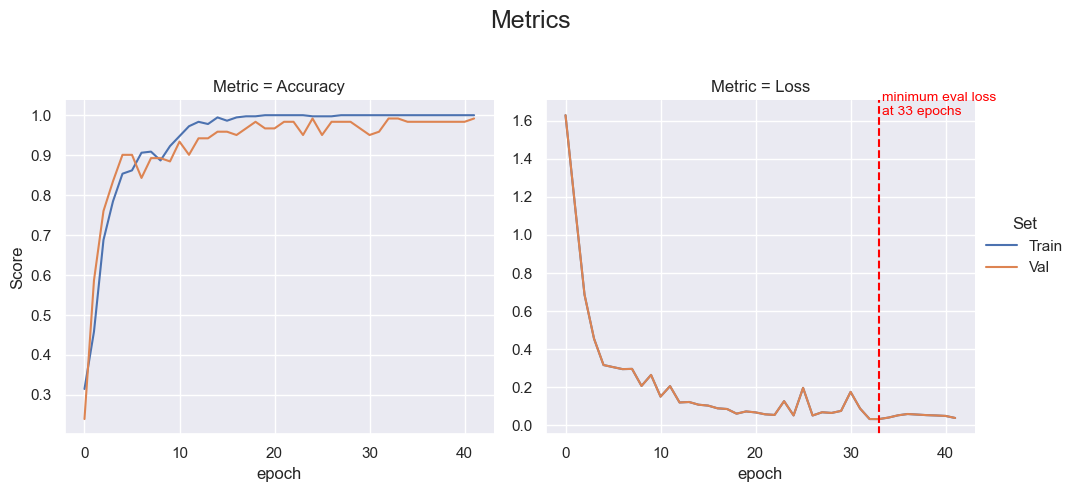

In [63]:
minimum = metrics[metrics.val_loss == metrics.val_loss.min()].epoch.values[0]
maximum = metrics.val_loss.max()

temp = pd.melt(metrics, id_vars=["epoch"],
                value_vars=['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], var_name='Set', value_name='Score')

temp['Metric'] = temp['Set'].apply(lambda x: x.split('_')[1].capitalize())
temp['Set'] = temp['Set'].apply(lambda x: x.split('_')[0].capitalize())

sns.set()
rel = sns.relplot(temp, x="epoch", y="Score", col="Metric", hue="Set", kind="line", facet_kws={'sharey': False, 'sharex': True})
rel.fig.suptitle('Metrics', fontsize=18)
rel.fig.subplots_adjust(top=.8)
plt.axvline(minimum, color='red', linestyle="--")
plt.text(minimum+0.3, maximum, f'minimum eval loss\nat {minimum} epochs', color="red", fontsize = 10)
plt.show()

# TinyML PIPELINE

In [1]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [ ]:
CBAM_EDU.save(MODEL_TF)